In [10]:
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast
# noinspection PyUnresolvedReferences
from xLSTM.xLSTM import xLSTM

In [2]:
df_train_raw = pd.read_csv('data/train.csv', encoding='cp1252')
df_val_raw = pd.read_csv('data/test.csv', encoding='cp1252')

df = pd.concat([df_train_raw, df_val_raw], ignore_index=True)
df = df.filter(["text", "sentiment"]).dropna()

valid_sentiments = {"negative", "neutral", "positive"}
label_map = {"negative": 0, "neutral": 1, "positive": 2}

df = df[df["sentiment"].isin(valid_sentiments)].copy()
df["label"] = df["sentiment"].map(label_map).astype(int)
df["text"] = df["text"].astype(str)

df['label'].value_counts(normalize=True)

label
1    0.404559
2    0.312278
0    0.283162
Name: proportion, dtype: float64

In [3]:
df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    shuffle=True,
    random_state=42
)

In [4]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

SEQ_LENGTH = 64

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.texts = dataframe["text"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [17]:
class xLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes=3, hidden_dim=128, max_len=64,
                 config_layers='m', dropout=0.5, padding_idx=0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=padding_idx)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_dim))

        dummy_x = torch.zeros(1, max_len, hidden_dim).to(device)
        self.xlstm = xLSTM(config_layers, dummy_x)

        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        seq_len = input_ids.size(1)
        pos_encoding = self.positional_encoding[:, :seq_len, :]

        x = self.embedding(input_ids) + pos_encoding
        x = x * attention_mask.unsqueeze(-1)

        x = self.xlstm(x)

        masked_sum = (x * attention_mask.unsqueeze(-1)).sum(dim=1)
        lengths = attention_mask.sum(dim=1).clamp(min=1).unsqueeze(1)
        pooled = masked_sum / lengths

        return self.classifier(pooled)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(SentimentDataset(df_train, SEQ_LENGTH), batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(SentimentDataset(df_val, SEQ_LENGTH), batch_size=32, shuffle=False, num_workers=4)

model = xLSTMClassifier(
    vocab_size=tokenizer.vocab_size,
    hidden_dim=256,
    max_len=SEQ_LENGTH,
    padding_idx=tokenizer.pad_token_id
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 7

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item() * input_ids.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    print(f"Epoch {epoch + 1}/{EPOCHS} - loss: {total_loss / total:.3f}" )

Epoch 1/7 - loss: 0.930
Epoch 2/7 - loss: 0.589
Epoch 3/7 - loss: 0.261
Epoch 4/7 - loss: 0.162
Epoch 5/7 - loss: 0.114
Epoch 6/7 - loss: 0.107
Epoch 7/7 - loss: 0.089


In [19]:
all_keys_list = []

for key in model.xlstm.state_dict().keys():
    print(key)
    all_keys_list.append(key)


layers.0.ln.weight
layers.0.ln.bias
layers.0.left.weight
layers.0.left.bias
layers.0.right.weight
layers.0.right.bias
layers.0.conv.conv.weight
layers.0.conv.conv.bias
layers.0.lskip.weight
layers.0.lskip.bias
layers.0.wq.blocks.0.weight
layers.0.wq.blocks.0.bias
layers.0.wq.blocks.1.weight
layers.0.wq.blocks.1.bias
layers.0.wq.blocks.2.weight
layers.0.wq.blocks.2.bias
layers.0.wq.blocks.3.weight
layers.0.wq.blocks.3.bias
layers.0.wk.blocks.0.weight
layers.0.wk.blocks.0.bias
layers.0.wk.blocks.1.weight
layers.0.wk.blocks.1.bias
layers.0.wk.blocks.2.weight
layers.0.wk.blocks.2.bias
layers.0.wk.blocks.3.weight
layers.0.wk.blocks.3.bias
layers.0.wv.blocks.0.weight
layers.0.wv.blocks.0.bias
layers.0.wv.blocks.1.weight
layers.0.wv.blocks.1.bias
layers.0.wv.blocks.2.weight
layers.0.wv.blocks.2.bias
layers.0.wv.blocks.3.weight
layers.0.wv.blocks.3.bias
layers.0.i_gate.weight
layers.0.i_gate.bias
layers.0.f_gate.weight
layers.0.f_gate.bias
layers.0.o_gate.weight
layers.0.o_gate.bias
layers.0.l

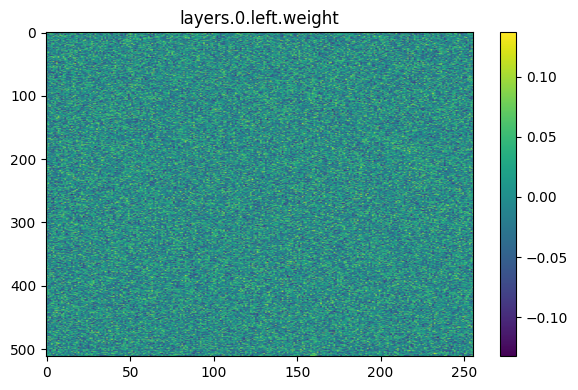

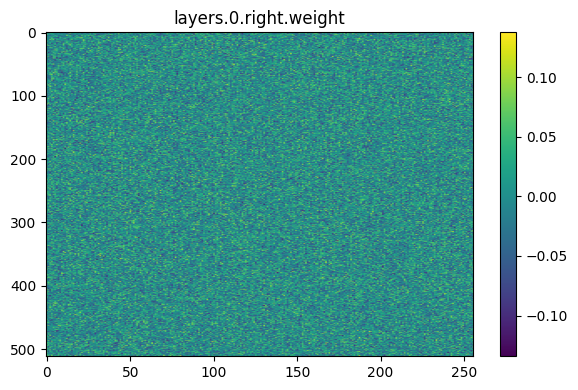

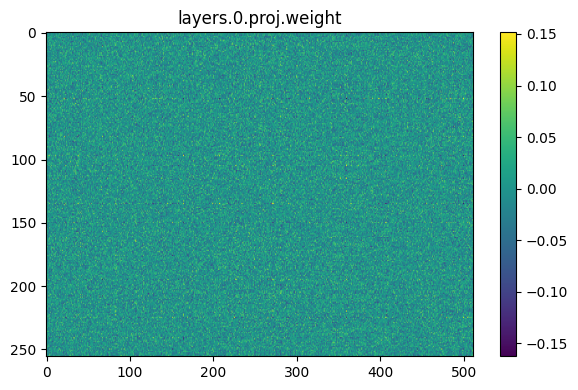

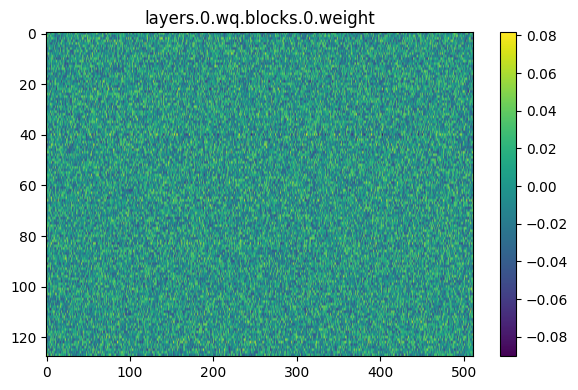

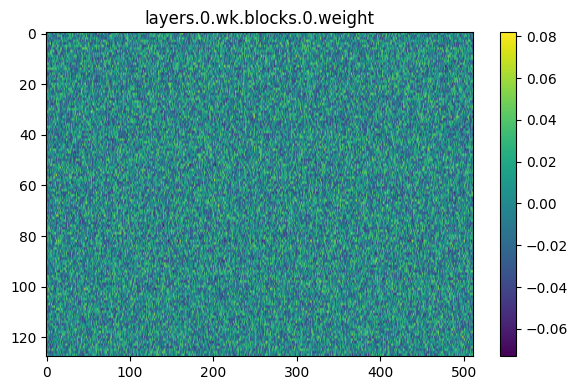

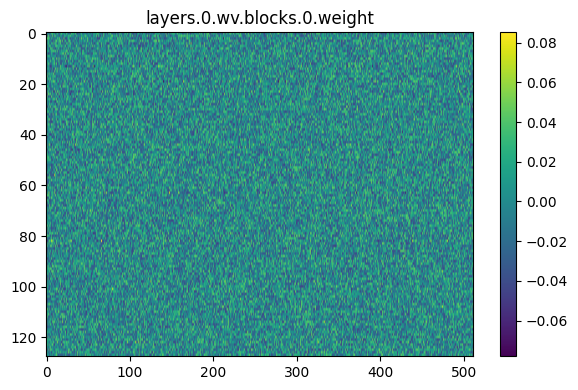

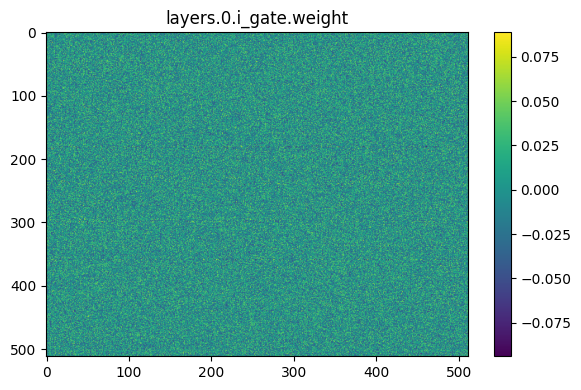

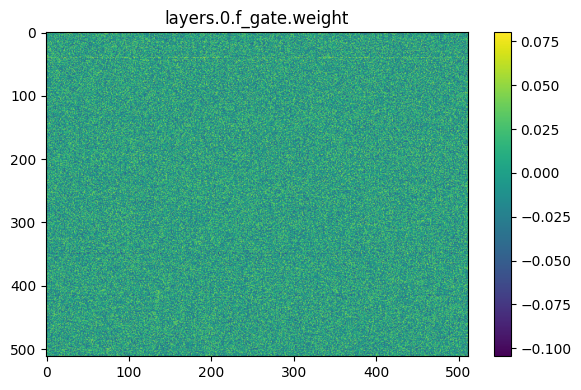

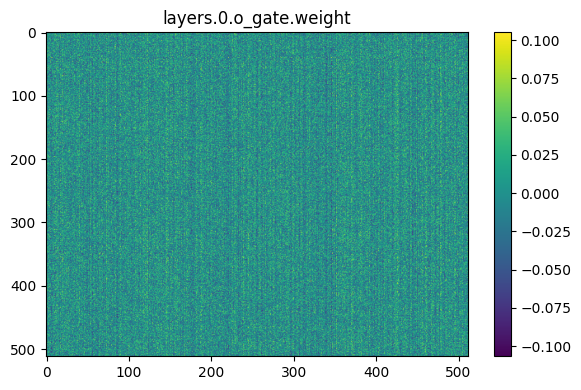

In [21]:
state_dict = model.xlstm.state_dict()

def plot_matrix(tensor, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(tensor.cpu().numpy(), cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

layer_list = [
    "layers.0.left.weight",
    "layers.0.right.weight",
    "layers.0.proj.weight",
    "layers.0.wq.blocks.0.weight",
    "layers.0.wk.blocks.0.weight",
    "layers.0.wv.blocks.0.weight",
    "layers.0.i_gate.weight",
    "layers.0.f_gate.weight",
    "layers.0.o_gate.weight",
    "layers.0.conv.conv.weight"
]

for key in layer_list:
    tensor = state_dict.get(key)
    if tensor is not None and tensor.ndim == 2:
        plot_matrix(tensor, title=key)